In [1]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import math
import functools
import numpy as np
import scipy.interpolate
from scipy import interpolate
import pandas as pd
import pickle as pkl

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

##### Возможно ранее я где-то совершил ошибку при интерполировании сигналов рассеяния, поэтому, пройду весь путь сначала

In [46]:
fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) 
#формируем список файлов x для считывания в цикле
xw = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/01.txt',sep='\t')
colums=list(xw.columns.values) #установил имена колонок
rows=list(xw.index.values)  #установил имена строчек

In [47]:
X=np.zeros([35,206,55]) #инициализирую массив нулей

In [48]:
# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)

In [49]:
# Считаем наши данные в наш тензор
for i in range(0,35):
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[i],sep='\t')
    x = x.fillna(0)
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    X[i,:,:]=np.array(x)

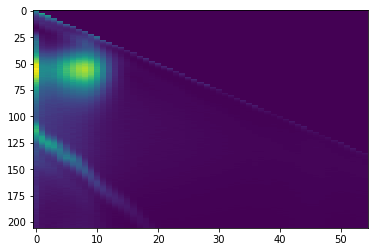

In [50]:
plt.imshow(X[34,:,:],aspect='auto')
plt.show()

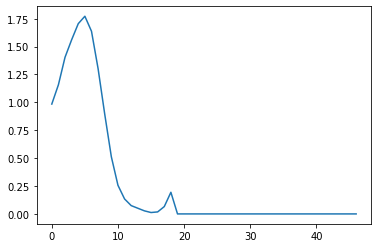

In [51]:
plt.plot(X[34,53,3:50])
plt.show();

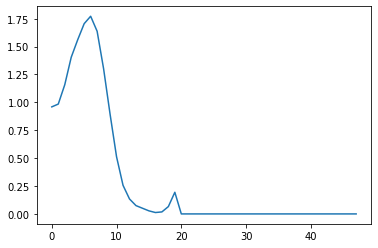

In [52]:
plt.plot(X[34,53,2:50])
plt.show();

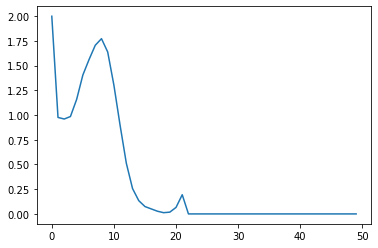

In [53]:
plt.plot(X[34,53,0:50])
plt.show();

#### Как видно из графиков чуть выше, к нашему спектру вначале дабавился ещё и эмиссионный спектр. В прошлый раз я пытался его интерполировать, что бы не терять данные, сейчас просто отрежу первые пару длин волн.

In [54]:
koef=3 #количество столбцов, которые будут отрезаны
X=X[:,:,koef:]

In [55]:
ll=xw.columns.values[koef:] #колонки
lrl=xw.index.values #строчки
lrl=lrl.astype(float)
ll=ll.astype(float)
Xw=np.zeros([len(lrl),len(ll)]) #инициализирую массив нулей
cons=3400
def lo(t):
    return  1/((1/t) - (cons/1e7))
for i in range(0,len(lrl)):
    for j in range(0,len(ll)):
        if (
                (math.fabs((2*ll[j])-(lrl[i]))<30) or 
                (math.fabs(ll[j]-(lrl[i]))<30) or
                (math.fabs((2*lrl[i])-(lo(ll[j])))<30) or 
                (math.fabs(lrl[i]-lo(ll[j]))<30)):
            Xw[i,j]=1.0  #собираю булеву матрицу
Xw=Xw[:,koef:]

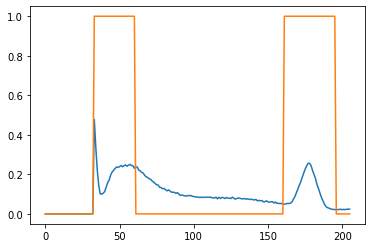

In [78]:
plt.plot(X[3,:,10])
plt.plot(Xw[:,10])
plt.show();

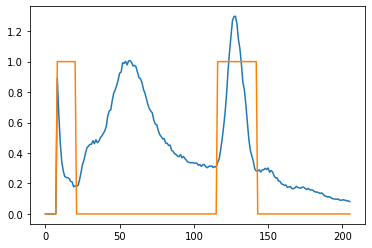

In [79]:
plt.plot(X[3,:,0])
plt.plot(Xw[:,0])
plt.show();

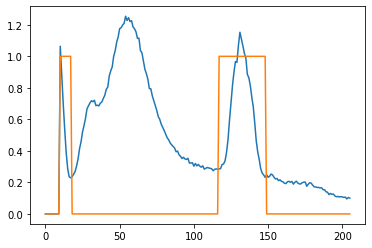

In [80]:
plt.plot(X[3,:,1])
plt.plot(Xw[:,1])
plt.show();

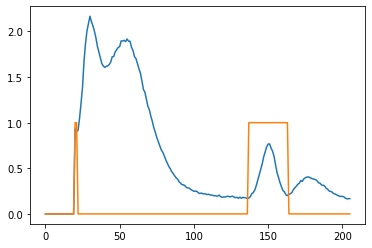

In [87]:
plt.plot(X[3,:,5])
plt.plot(Xw[:,5])
plt.show();

#### Как видно из графиков, иногда интерполяционный коридор слишком широкий, а иногда, наоборот, слишком узкий, поэтому, напишу функцию, которая подгоняет эту ширину

In [60]:
def function_1 (data, bool_vector, relation):
    for i in range(0,len(bool_vector)-1):
        if data[i]==0:
            bool_vector[i]=0
            continue
        if (bool_vector[i]==1) and (bool_vector[i+1]==0):
            while data[i]<=data[i+1]:
                bool_vector[i]=0
                i-=1
            if ((data[i]/data[i+1])>=relation):
                bool_vector[i+1]=1
        if (bool_vector[i]==0) and (bool_vector[i+1]==1):
            while data[i]>=data[i+1]:
                bool_vector[i+1]=0
                i+=1
    # Я заметил, что на некоторых образцах коридор 1 оказывается настолько широким, что помимо сигнала рассеяния
    # полностью захватывает наш сигнал, поэтому нужно ещё раз пройтись (Смотреть образец №3)
    for i in range(0,len(bool_vector)-1):
        
    return bool_vector

In [ ]:
def function_2 (data, bool_matrix, relation):
    for i in range(0,data.shape[1]):
        for j in range(0,da)
        bool_matrix[:,i]=function_1(data[34,:,i],Xw[:,i],1.01)

In [71]:
for i in range(0,32):
    Xw[:,i]=function_1(X[3,:,i],Xw[:,i],1.01)

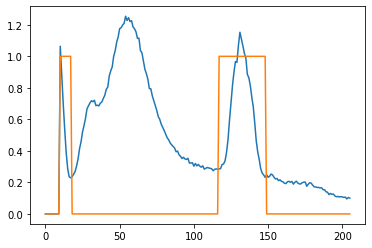

In [74]:
plt.plot(X[3,:,1])
plt.plot(Xw[:,1])
plt.show();

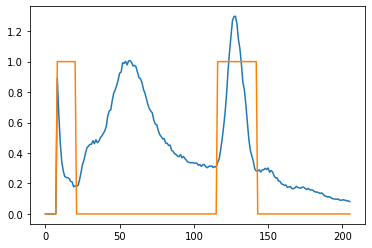

In [75]:
plt.plot(X[3,:,0])
plt.plot(Xw[:,0])
plt.show();

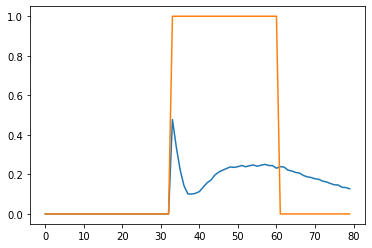

In [92]:
plt.plot(X[3,0:80,10])
plt.plot(Xw[0:80,10])
plt.show();

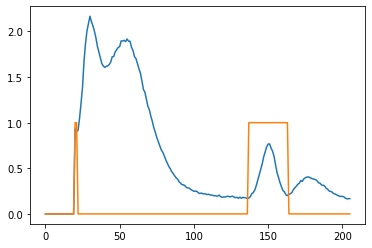

In [77]:
plt.plot(X[3,:,5])
plt.plot(Xw[:,5])
plt.show();

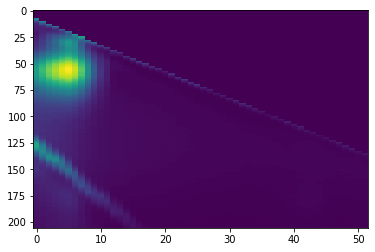

In [88]:
plt.imshow(X[4,:,:],aspect='auto')
plt.show()